In [202]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.svm import SVC
from yellowbrick.model_selection import LearningCurve

---

## № 1

1. Загрузите предложенный вам датасет с помощью функции `sklearn.datasets.fetch_openml`.
2. Выведите текстовое описание загруженного датасета.
3. Определите какая бизнес-задача ставится.
4. Переведите бизнес-задачу в задачу машинного обучения.


In [203]:
# Загружаем датасет
dataset = fetch_openml("olindda_outliers")
dataset.data.head(5)

,x_0,x_1
0,82.136441,-74.928833
1,61.100717,-67.410193
2,36.683335,-68.236317
3,66.985287,-77.428261
4,79.611189,-68.236317


In [204]:
dataset.target.head(5)

0    normal
1    normal
2    normal
3    normal
4    normal
Name: label, dtype: category
Categories (4, object): ['normal', 'novelty1', 'novelty2', 'outlier']

In [205]:
# Описание датасета
print(dataset.DESCR)

Outliers data set extracted from the Illustration (Fig. 3) in &quot;Novelty detection with application to data
streams&quot;

Downloaded from openml.org.


Датасет для поиска выбросов

**Эндогенные переменные:**

-   X_0
-   X_1

**Экзогенная переменная:**

-   Нормальность


---

## № 2

1. Проведите предварительный анализ датасета.
2. Выведите основную статистическую информацию о данных.
3. Проверьте дисбаланс целевого признака.


In [206]:
X = dataset.data
y = dataset.target

In [207]:
# Превращаем в задачу бинарной классификации
y[y != "normal"] = "outlier"

In [208]:
# Статистика по катеригориальным данным не выводится
X.describe()

,x_0,x_1
count,75.000000,75.000000
mean,65.620992,-49.747495
std,21.684487,22.435307
min,29.239499,-92.335341
25%,44.741727,-70.745923
50%,63.735546,-49.721525
75%,84.716481,-28.990868
max,104.972930,-15.474583


In [209]:
# Посмотрим на дисбаланс целевого признака

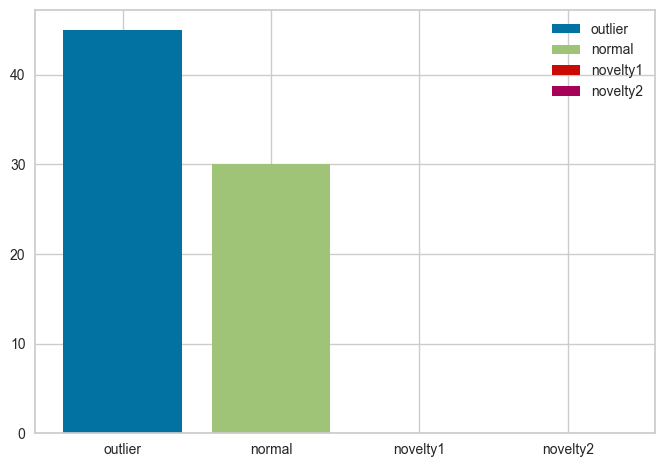

In [210]:
for key, value in y.value_counts().items():
    plt.bar(key, value, label=key)
    plt.legend()

Видно что есть дисбаланс классов


---

## № 3

1. Убедитесь, что данные пригодны для моделирования.
2. В данных не должно быть пропущенных значений, все признаки должны быть численными.
3. Если эти условия нарушаются, исправьте это.


In [211]:
# Преобразуем `y` в числовые значения
y = y.cat.codes != 0

Тк мы уже заменили все данные на численные, осталось проверить на пропуски


In [212]:
X.isna().any(axis=0)

x_0    False
x_1    False
dtype: bool

In [213]:
y.isna().any()

False

Везде False, пропущенных значений нет


---

## № 4

1. Обучите любую линейную модель, которая решает поставленную задачу.
2. Выведите с помощью метода `score()` результат метрики оценки модели.
3. Опишите какая метрика подсчитывается в методе `score()`.


In [214]:
# Обучим модель, добавив фиктивную переменную
linear = LogisticRegression().fit(sm.add_constant(X), y)
y_pred = linear.predict(sm.add_constant(X))
y_pred_proba = linear.predict_proba(sm.add_constant(X))

In [215]:
# Выведем метрику точности
linear.score(sm.add_constant(X), y)
# У линейной модели по умолчанию считается mean_accuracy

0.9333333333333333

---

## № 5

1. К поставленной задачи машинного обучения подберите еще 3 метрики.
2. С помощью их оцените обученную линейную модель.


In [216]:
print(f"f1_score: {f1_score(y, y_pred):.4f}")
# Точность - чем больше, тем меньше ложно позитивных значений
print(f"recall_score: {recall_score(y, y_pred):.4f}")
# Полнота - чем больше, тем больше положительных было успешно обнаружено
print(f"precision_score: {precision_score(y, y_pred):.4f}")

f1_score: 0.9412
recall_score: 0.8889
precision_score: 1.0000


In [217]:
# Повторим оценку используя кросс-валидацию

# Разбиваем датасет
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=1223)

# Приминяем метрики
for metric in ("f1_macro", "precision", "recall"):
    cv_results = cross_val_score(
        LogisticRegression(),  # модель
        X,
        y,
        cv=skf,
        scoring=metric,
        n_jobs=-1,
    )

    # print("Кросс-валидация: ", cv_results)
    print(f"{metric}: {cv_results.mean():.4f}")

f1_macro: 0.8990
precision: 0.9667
recall: 0.8889


---

## № 6

1. Постройте для этой модели кривые ROC.
2. Вычислите для этой модели метрики площади под кривыми ROC-AUC.
3. Найдите оптимальное значения порога модели.


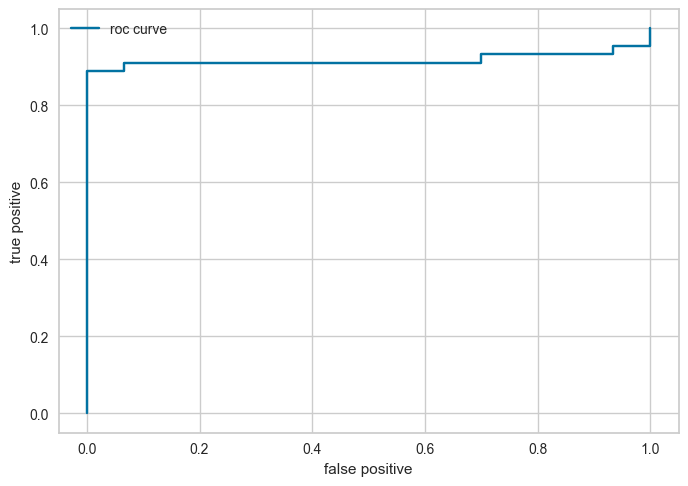

In [218]:
fp, tp, thresholds = roc_curve(y, y_pred_proba[:, 1])

plt.plot(fp, tp, label="roc curve")
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.legend()
plt.show()

In [219]:
print(f"Площадь под кривой: {roc_auc_score(y, y_pred_proba[:, 1]):.4f}")

Площадь под кривой: 0.9178


Найдем оптимальное значение порога, как точку ближнюю к левому верхнему углу


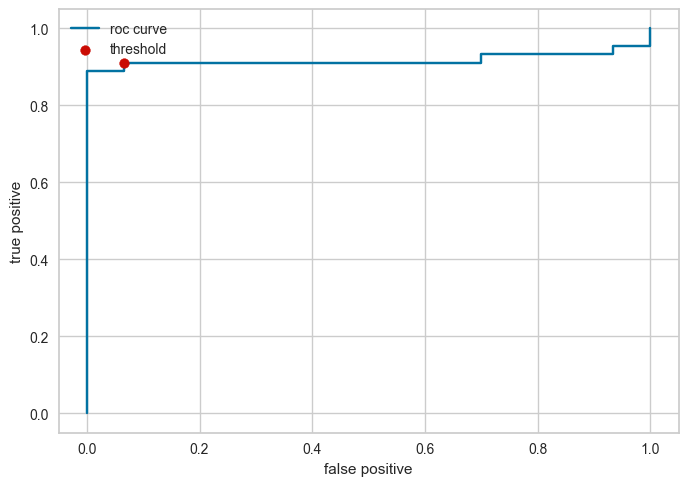

Порог: 0.45553374620589027


In [220]:
threshold_key = np.argmin((fp**2 + (1 - tp) ** 2) ** 0.5)
threshold = thresholds[threshold_key]


plt.plot(fp, tp, label="roc curve")
plt.scatter(fp[threshold_key], tp[threshold_key], c="r", zorder=2, label="threshold")
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.legend()
plt.show()
print(f"Порог: {threshold}")

---

## № 7

1. Постройте для этой модели кривые PR.
2. Вычислите для этой модели метрики площади под кривыми PR-AUC.
3. Найдите оптимальное значения порога модели.


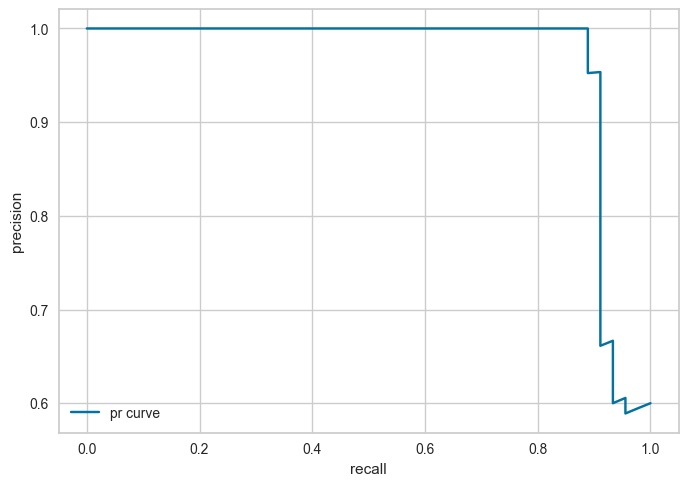

In [221]:
precision, recall, thresholds = precision_recall_curve(y, y_pred_proba[:, 1])

plt.plot(recall, precision, label="pr curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend()
plt.show()

In [222]:
print(f"Площадь под кривой: {auc(recall, precision):.4f}")

Площадь под кривой: 0.9646


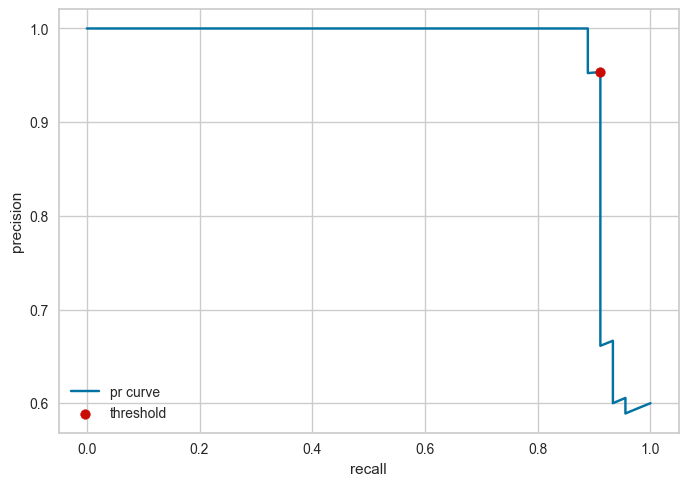

Порог: 0.45553374620589027


In [223]:
threshold_key = np.argmin(((1 - precision) ** 2 + (1 - recall) ** 2) ** 0.5)
threshold = thresholds[threshold_key]


plt.plot(recall, precision, label="pr curve")
plt.scatter(
    recall[threshold_key], precision[threshold_key], c="r", zorder=2, label="threshold"
)
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend()
plt.show()
print(f"Порог: {threshold}")

Найдем оптимальное значение порога, как точку ближнюю к правому верхнему углу


---

## № 8

1. Обоснуйте выбор типа разбиения данных при кросс-валидации для вашей задачи машинного обучения.
2. Обучите любую другую модель используя кросс-валидацию данных.


Выше использовалась кросс-валидация, метод `StratifiedKFold` был взят из-за наличияя дизбаланса в целевом классе


Обучим другую модель и проведем кросс-валидацию


In [224]:
# У модели ближайших соседей тоже получилась хорошая точность
res = cross_val_score(
    SVC(),  # модель
    X,  # матрица признаков
    y,  # вектор цели
    cv=skf,  # тип разбиения
    scoring="f1_macro",  # метрика
    n_jobs=-1,
)
res.mean()

0.9066666666666667

Модель опорных векторов соседей показала хорошую точность

---

## № 9

1. Проведите диагностику любой модели.
2. Постройте кривые обучения.
3. Сделайте вывод о переобученности или недообученности модели.


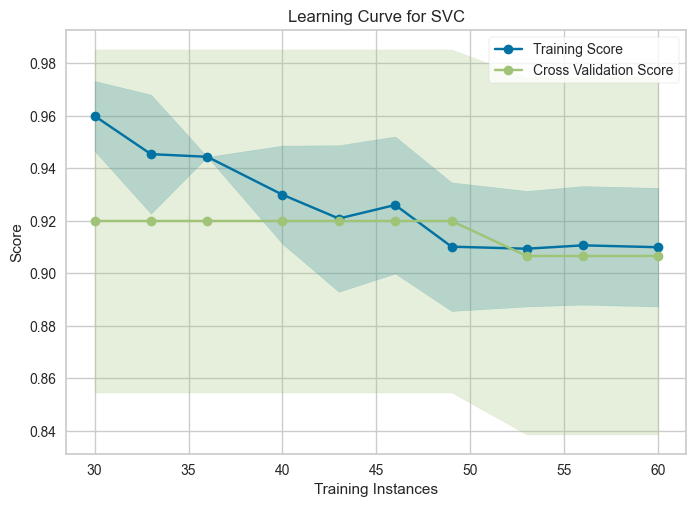

In [225]:
visualizer = (
    LearningCurve(SVC(), train_sizes=np.linspace(0.5, 1.0, 10)).fit(X, y).show()
)
# Модель хорошо обучена, кривые обучения сходятся и имеют высокую точность

---

## № 10

1. Исследуйте как любой из гиперпараметров модели влияет на эффективность модели.


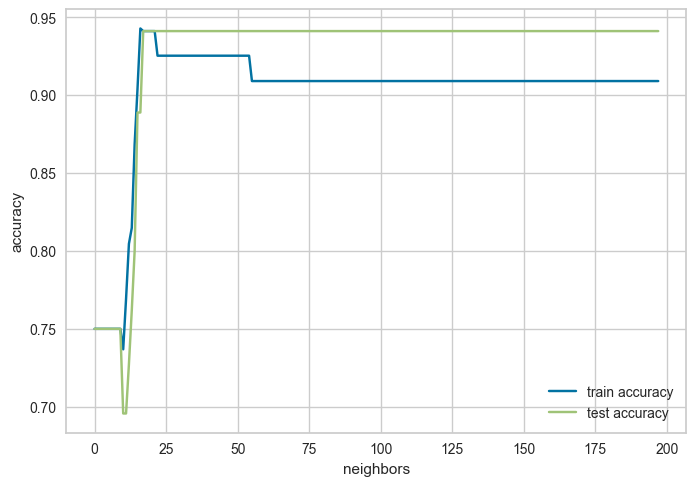

In [226]:
# Построим график влияния значения стратификации на эффективность модели
scores_train = []
scores_test = []
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1223
)
for i in np.arange(1,100, 0.5):
    model = SVC(C=i/50).fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    scores_train.append(f1_score(y_train, y_pred_train))
    scores_test.append(f1_score(y_test, y_pred_test))

plt.plot(scores_train, label="train accuracy")
plt.plot(scores_test, label="test accuracy")
plt.legend()
plt.xlabel("neighbors")
plt.ylabel("accuracy")
None

Видно что оптимальными значениями стратификации являются значения 10-16